In [28]:
import numpy as np
import torch
import torch.nn as nn # contains functions needed to defined layers
import torch.nn.functional as F # contains activation functions
import torch.optim as optim
from torchvision import datasets, transforms #torchvision
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import copy

In [29]:
class Net(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #qui avrò 32 filtri
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [30]:
class BigCNN(nn.Module):
    def __init__(self):
        super(BigCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.4)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=2)
        self.bn6 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.4)

        self.fc1 = nn.Linear(1024, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.bn3(x)
        x = self.dropout1(x)

        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.bn4(x)

        x = self.conv5(x)
        x = nn.functional.relu(x)
        x = self.bn5(x)

        x = self.conv6(x)
        x = nn.functional.relu(x)
        x = self.bn6(x)
        x = self.dropout2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.bn7(x)
        x = self.dropout3(x)

        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [31]:
def train(model, device, train_loader, optimizer, epoch):

    size = len(train_loader.dataset)
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            loss, current = loss, (batch_idx + 1) * len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        losses.append(loss.item())
    return np.mean(losses)

In [32]:
def test(model, device, test_loader ):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # at test time we don't need gradient calculation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print(f"Test Error: \n Accuracy: {(test_acc):>0.2f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_acc

In [33]:
# PARAMETERS
device = torch.device("cuda") # to use the GPU
batch_size = 64
epochs = 20
lr = 0.1

# MODEL AND OPTIMIZER
model = BigCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# NUMBER OF PARAMETERS
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

326410


In [34]:
# DATA

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

size = len(train_dataset)
train_dataset, val_dataset = random_split(train_dataset, [int(size*0.9), int(size*0.1)])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [35]:
# TRAIN LOOP
best_model = None
best_accuracy = 0
train_loss = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    tr_loss = train(model, device, train_loader, optimizer, epoch)
    te_loss, te_accuracy = test(model, device, val_loader)

    train_loss.append(tr_loss)
    test_loss.append(te_loss)
    test_acc.append(te_accuracy)

    if (te_accuracy > best_accuracy):
      print("Saving model...")
      best_accuracy = te_accuracy
      best_model = copy.deepcopy(model)

print("Done!")


Epoch 1
-------------------------------
loss: 2.730417  [   64/48000]
loss: 0.188707  [ 6464/48000]
loss: 0.192008  [12864/48000]
loss: 0.100867  [19264/48000]
loss: 0.069665  [25664/48000]
loss: 0.120791  [32064/48000]
loss: 0.017214  [38464/48000]
loss: 0.101252  [44864/48000]
Test Error: 
 Accuracy: 98.80%, Avg loss: 0.036504 

Saving model...
Epoch 2
-------------------------------
loss: 0.036517  [   64/48000]
loss: 0.021006  [ 6464/48000]
loss: 0.021989  [12864/48000]
loss: 0.013015  [19264/48000]
loss: 0.022783  [25664/48000]
loss: 0.017353  [32064/48000]
loss: 0.032087  [38464/48000]
loss: 0.108467  [44864/48000]
Test Error: 
 Accuracy: 99.35%, Avg loss: 0.025507 

Saving model...
Epoch 3
-------------------------------
loss: 0.058124  [   64/48000]
loss: 0.033188  [ 6464/48000]
loss: 0.008080  [12864/48000]
loss: 0.046690  [19264/48000]
loss: 0.030815  [25664/48000]
loss: 0.121925  [32064/48000]
loss: 0.038718  [38464/48000]
loss: 0.040585  [44864/48000]
Test Error: 
 Accuracy

In [37]:
te_loss, te_accuracy = test(best_model, device, test_loader)
print(te_accuracy)


Test Error: 
 Accuracy: 99.35%, Avg loss: 0.025478 

99.35


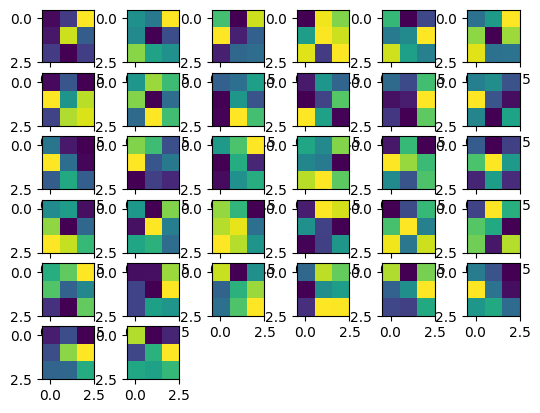

In [82]:
# FILTERS
kernel = model.conv1.weight.cpu()
kernel = kernel.detach()
kernel = np.array(kernel)
figure, ax = plt.subplots(6, 6)
for i in range(6):
  for j in range(6):
    # print(6*i + j)
    if 6*i + j < len(kernel):
      ax[i][j].imshow(kernel[6*i + j].reshape(3,3))
    else:
      ax[i][j].remove()

##Exercise 0
Create a plot of the values of the training losses and training accuracies.

This can help to monitor how the training is going.

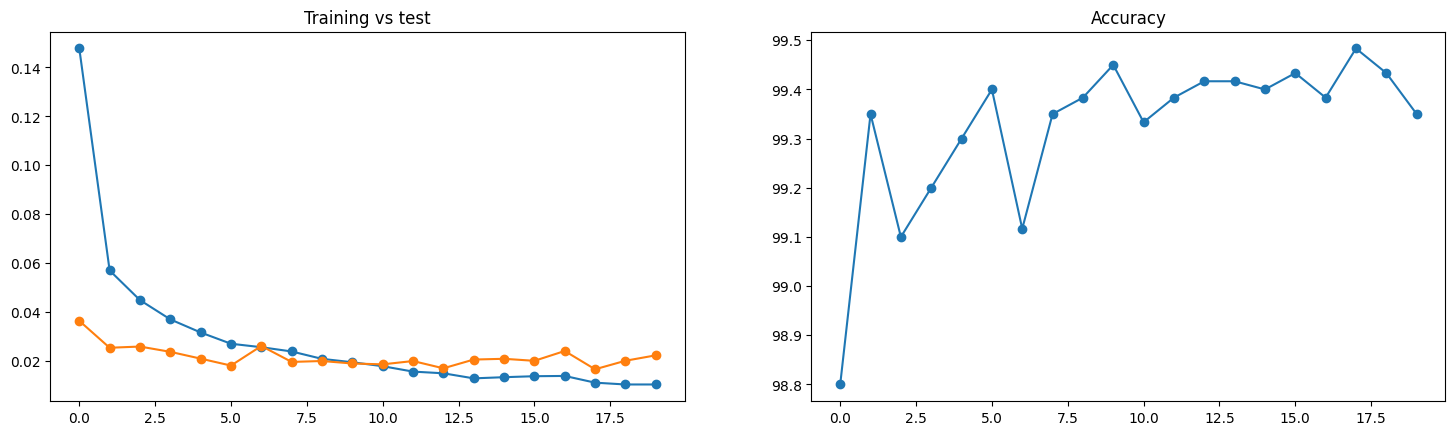

In [38]:
train_loss = np.array(train_loss).ravel()
test_loss = np.array(test_loss).ravel()
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(18)
ax[0].set_title("Training vs test")
ax[1].set_title("Accuracy")
ax[0].plot(np.arange(0, len(train_loss), 1), train_loss, '-o')
ax[0].plot(np.arange(0, len(test_loss), 1), test_loss, '-o')
ax[1].plot(np.arange(0, epochs, 1), test_acc, '-o')

## Exercise 1

Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding)

How the performance change? Why?

## Exercise 2

Try to work with the hyperparameters (batch_size, learning_rate, ...).

In particular try to focus on the optimization part. Change algorithm, momentum, parameters...

How can it be improved?